In [1]:
#import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing the dataset
dataset = pd.read_csv('customer_segmentation.csv')


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


In [12]:
from IPython.core.display_functions import display

dataset.head() #first 5 entries of the dataset to understand the data we are dealing with


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


In [13]:

print("Dataset info:")
display(dataset.info())
print()
print("Dataset shape:")
display(dataset.shape) #number of rows and columns of our dataset
print()
display(dataset.describe()) #compute some useful descriptive statistics which summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding NaN values


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       13801 non-null  object 
 1   customer_id                    13801 non-null  object 
 2   order_status                   13801 non-null  object 
 3   order_purchase_timestamp       13801 non-null  object 
 4   order_approved_at              13801 non-null  object 
 5   order_delivered_carrier_date   13801 non-null  object 
 6   order_delivered_customer_date  13801 non-null  object 
 7   order_estimated_delivery_date  13801 non-null  object 
 8   payment_type                   13801 non-null  object 
 9   payment_installments           13801 non-null  int64  
 10  payment_value                  13801 non-null  float64
 11  customer_unique_id             13801 non-null  object 
 12  customer_city                  1

None


Dataset shape:


(13801, 26)

,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,3.014637,194.349691,1.230491,130.947103,21.938168,49.300703,814.330411
std,2.801721,294.854258,0.737495,210.712421,18.567013,9.759529,648.790194
min,1.000000,0.050000,1.000000,0.850000,0.000000,8.000000,4.000000
25%,1.000000,66.750000,1.000000,40.000000,12.870000,43.000000,366.000000
50%,2.000000,120.290000,1.000000,79.000000,18.230000,52.000000,631.000000
75%,4.000000,206.780000,1.000000,139.000000,23.310000,57.000000,1030.000000
max,20.000000,7274.880000,13.000000,4590.000000,375.280000,69.000000,3985.000000


37ee401157a3a0b28c9c6d0ed8c3b24b    13
637617b3ffe9e2f7a2411243829226d0    12
1a611328643ae11146ba09a4425d2e12    12
af822dacd6f5cff7376413c03a388bb7    12
6c355e2913545fa6f72c40cbca57729e    11
                                    ..
80eb061ace1abe7c2ba1828e00492f23     1
9151a91cb186d1ca78dc97f0cd26cec4     1
6423db30ee1e8cbd5d066f414bde1a0e     1
e225050f709a0409b3a30c63fa35c6da     1
73d60420cd1a179b2d8887d538efe4c2     1
Name: order_id, Length: 11394, dtype: int64

KeyboardInterrupt: 

<AxesSubplot: >

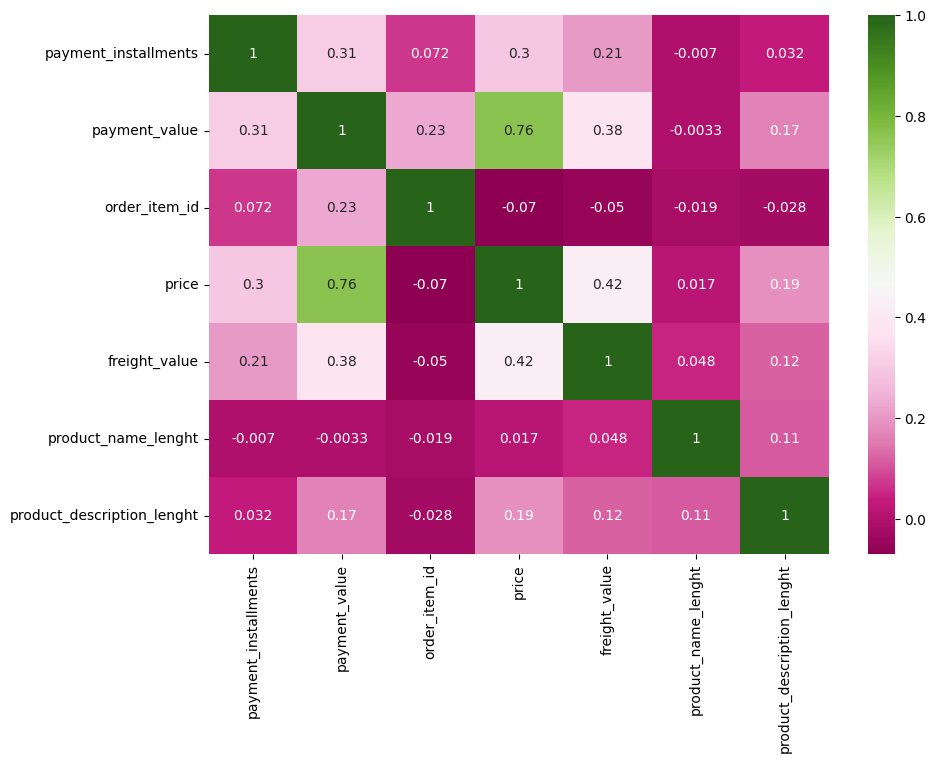

In [28]:
correlation = dataset.corr(numeric_only=True) #compute pairwise correlation of columns excluding NA/null values
table = plt.figure(figsize=(10,7))
sns.heatmap(correlation, annot=True, cmap="PiYG")

In [15]:
#non so se serve
snadv_df = pd.get_dummies(dataset)
snadv_df.head()

,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,order_id_0006ec9db01a64e59a68b2c340bf65a7,order_id_000aed2e25dbad2f9ddb70584c5a2ded,order_id_00130c0eee84a3d909e75bc08c5c3ca1,...,product_category_name_english_pet_shop,product_category_name_english_signaling_and_security,product_category_name_english_small_appliances,product_category_name_english_small_appliances_home_oven_and_coffee,product_category_name_english_sports_leisure,product_category_name_english_stationery,product_category_name_english_tablets_printing_image,product_category_name_english_telephony,product_category_name_english_toys,product_category_name_english_watches_gifts
0,1,141.46,1,118.7,22.76,29,178,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,135.82,1,116.9,18.92,29,178,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,128.04,1,118.7,9.34,29,178,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,279.30,1,116.9,22.75,29,178,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,279.30,2,116.9,22.75,29,178,0,0,0,...,0,0,0,0,0,0,0,0,0,0
